# Honeycomb solver 




In [123]:
import numpy as np
from ortools.sat.python import cp_model as cp
import gurobipy as gp
from collections import deque
from itertools import chain
import itertools
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
# THANKS FOR https://www.zhihu.com/question/683403503/answer/15700860878
# The formula is : \delta (n) = n(n - 1) + \lfloor (n + 1) / 3 \rfloor


169
	 Totally 29 Lines
Red: 57 Nodes
Blue: 57 Nodes
Green: 55 Nodes
{(-7, 0, 7): 1, (-7, 3, 4): 2, (-6, 1, 5): 3, (-5, -1, 6): 4, (-4, -3, 7): 5, (-7, 6, 1): 6, (-6, 4, 2): 7, (-5, 2, 3): 8, (-4, 0, 4): 9, (-3, -2, 5): 10, (-2, -4, 6): 11, (-1, -6, 7): 12, (-6, 7, -1): 13, (-5, 5, 0): 14, (-4, 3, 1): 15, (-3, 1, 2): 16, (-2, -1, 3): 17, (-1, -3, 4): 18, (0, -5, 5): 19, (1, -7, 6): 20, (-4, 6, -2): 21, (-3, 4, -1): 22, (-2, 2, 0): 23, (-1, 0, 1): 24, (0, -2, 2): 25, (1, -4, 3): 26, (2, -6, 4): 27, (-3, 7, -4): 28, (-2, 5, -3): 29, (-1, 3, -2): 30, (0, 1, -1): 31, (1, -1, 0): 32, (2, -3, 1): 33, (3, -5, 2): 34, (4, -7, 3): 35, (-1, 6, -5): 36, (0, 4, -4): 37, (1, 2, -3): 38, (2, 0, -2): 39, (3, -2, -1): 40, (4, -4, 0): 41, (5, -6, 1): 42, (0, 7, -7): 43, (1, 5, -6): 44, (2, 3, -5): 45, (3, 1, -4): 46, (4, -1, -3): 47, (5, -3, -2): 48, (6, -5, -1): 49, (7, -7, 0): 50, (3, 4, -7): 51, (4, 2, -6): 52, (5, 0, -5): 53, (6, -2, -4): 54, (7, -4, -3): 55, (6, 1, -7): 56, (7, -1, -6): 57, (-7, 1,

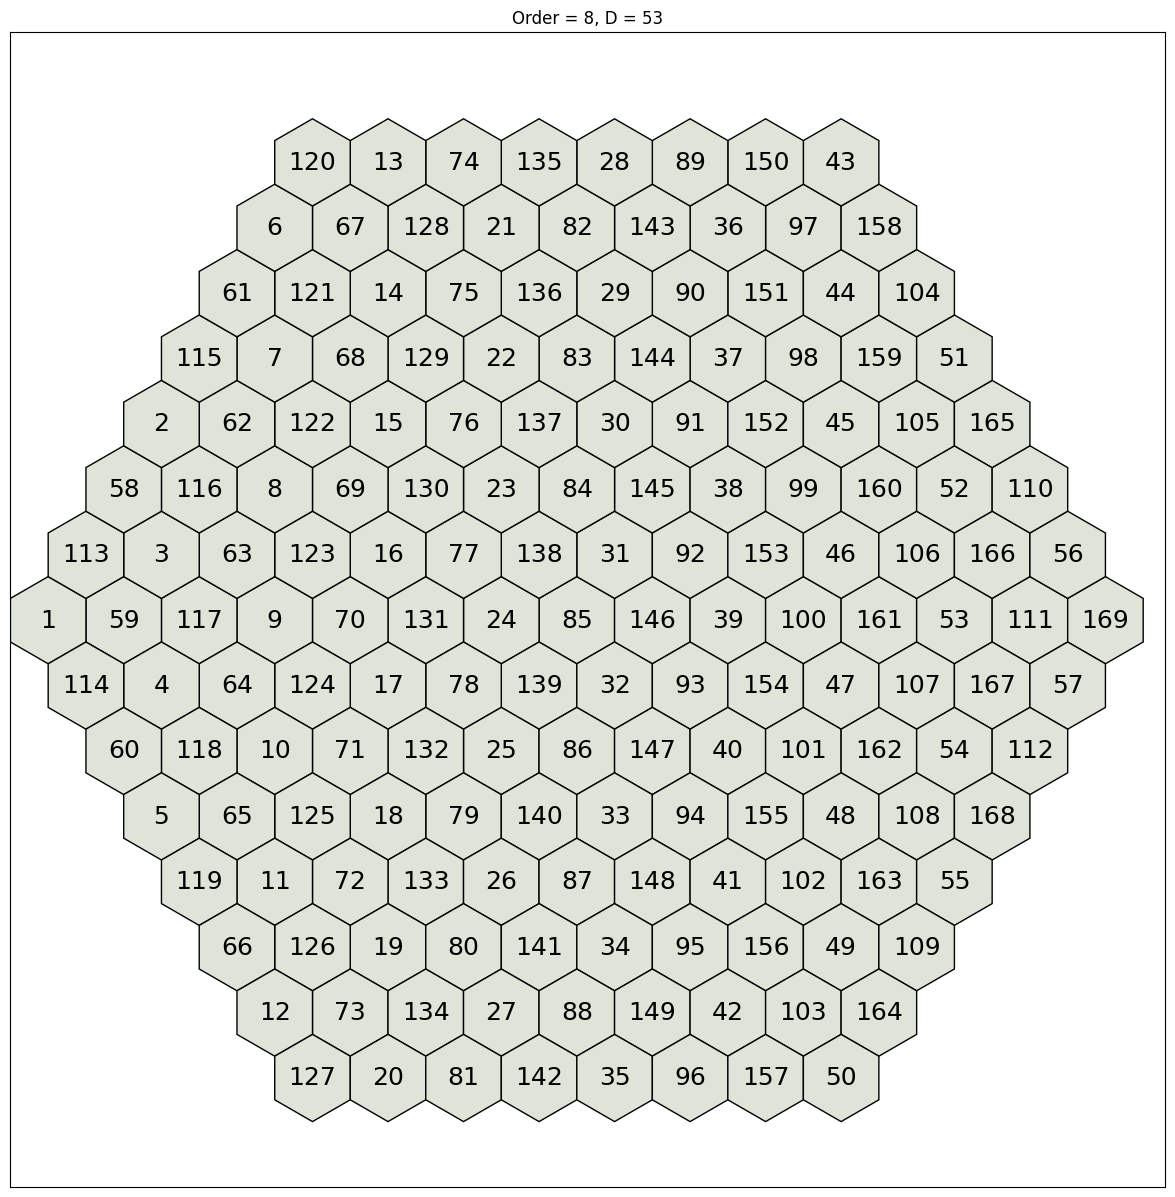

In [132]:
# 刻画每一圈的hex的圆心坐标 

def all_locs_with_coords(order, radius):
    if order == 1:
        coords = dict()
        coords[0,0,0] = [0,0]
        return [[0, 0, 0]], coords
    result = [[0,0,0]]
    last_iter = [[0,0,0]]
    coords = dict()
    coords[0,0,0] = [0,0]
    for order_ in range(1, order):
        new_iter = []
        for (q, r, s) in last_iter:
            six_neighbour = [
                [q + 1, r, s - 1],
                [q - 1, r, s + 1],
                [q, r + 1, s - 1],
                [q, r - 1, s + 1],
                [q - 1, r + 1, s],
                [q + 1, r - 1, s]
            ]
            for neighbor in six_neighbour:
                if neighbor not in result and neighbor not in new_iter:
                    new_iter.append(neighbor)
                    q1, r1, s1 = neighbor[0], neighbor[1], neighbor[2]
                    coords[q1, r1, s1] = [math.sqrt(3) * radius * (q1 - s1) / 2, radius * 3 * r1 / 2]
        last_iter = new_iter
        result = result + new_iter 
    return result, coords
        
def split_numbers(lengths):
    # 计算总和
    total = sum(lengths)
    # 生成从1到total的连续数字
    numbers = list(range(1, total + 1))

    # 计算所有长度的排列
    permutations = list(itertools.permutations(lengths))

    # 存储所有分法的结果
    results = []

    # 对每个排列进行分段
    for perm in permutations:
        split = []
        start = 0
        for length in perm:
            split.append(numbers[start:start + length])
            start += length
        results.append(split)
    return results

def all_locs(order):
    if order == 1:
        return [[0,0,0]]
    result = [[0,0,0]]
    last_iter = [[0,0,0]]
    for order_ in range(1, order):
        new_iter = []
        for (q, r, s) in last_iter:
            six_neighbour = [
                [q + 1, r, s - 1],
                [q - 1, r, s + 1],
                [q, r + 1, s - 1],
                [q, r - 1, s + 1],
                [q - 1, r + 1, s],
                [q + 1, r - 1, s]
            ]
            for neighbor in six_neighbour:
                if neighbor not in result and neighbor not in new_iter:
                    new_iter.append(neighbor)
        last_iter = new_iter
        result = result + new_iter 
    return result

def get_obj(result, order):
    obj = 9999
    locations = all_locs(order)
    N = len(locations)
    for (q, r, s) in locations:
        cur_min = 99999
        six_neighbour = [
                [q + 1, r, s - 1],
                [q - 1, r, s + 1],
                [q, r + 1, s - 1],
                [q, r - 1, s + 1],
                [q - 1, r + 1, s],
                [q + 1, r - 1, s],
            ]
        cur_neighbour = []
        cnt = 0
        for neighbour in six_neighbour:
            if neighbour in locations:
                cur_min = min(abs(result[neighbour[0], neighbour[1], neighbour[2]] - result[q, r, s]), cur_min)
        obj = min(cur_min, obj)
    return obj

def solver(order):
    result = all_locs(order)
    print(len(result))
    _, coords = all_locs_with_coords(order, 2)
    # print(f"HERE: {len(coords.keys())}")
    total_grids = []
    # print(coords)
    for k, v in coords.items():
        total_grids.append(v + [k[0], k[1], k[2]])
    sorted_array = sorted(total_grids, key=lambda x: (x[0], -x[1]))
    single_x = []
    for total_grid in sorted_array:
        if total_grid[0] not in single_x:
            single_x.append(total_grid[0])

    print(f"\t Totally {len(single_x)} Lines")

    firsts = []
    seconds = []
    thirds = []

    for total_grid in sorted_array:
        if single_x.index(total_grid[0]) % 3 == 0:
            firsts.append(total_grid)
        elif single_x.index(total_grid[0]) % 3 == 1:
            seconds.append(total_grid)
        elif single_x.index(total_grid[0]) % 3 == 2:
            thirds.append(total_grid)
        # print(total_grid)

    print(f"Red: {len(firsts)} Nodes")
    print(f"Blue: {len(seconds)} Nodes")
    print(f"Green: {len(thirds)} Nodes")

    lengths = [len(firsts), len(seconds), len(thirds)]
    combinations = []
    all_splits = split_numbers(lengths)
    idx_cores = list(itertools.permutations([0,1,2]))

    for idx, p in enumerate(all_splits):
        tmp = [[0], [0], [0]]
        tmp[idx_cores[idx][0]] = p[0]
        tmp[idx_cores[idx][1]] = p[1]
        tmp[idx_cores[idx][2]] = p[2]
        combinations.append(tmp)


    fin_result = dict()
    fin_obj = 0
    for comb in combinations:
        result = dict()

        first_nums = comb[0]
        second_nums = comb[1]
        third_nums = comb[2]
        for idx, line in enumerate(firsts):
            result[line[2], line[3], line[4]] = comb[0][idx]
        
        for idx, line in enumerate(seconds):
            result[line[2], line[3], line[4]] = comb[1][idx]
        
        for idx, line in enumerate(thirds):
            result[line[2], line[3], line[4]] = comb[2][idx]
        
        obj = get_obj(result, order)
        if obj > fin_obj:
            fin_obj = obj
            fin_result = result
        # for k, v in result.items():
        #     print(k, v)

    print(fin_result)
    return fin_result



# 创建一个函数来计算六边形的中心坐标
def get_hex_coordinates(order, radius):
    nodes, coords = all_locs_with_coords(order, radius)
    hex_coords = []  # 中心六边形坐标
    directions = [(1, 0), (0.5, np.sqrt(3)/2), (-0.5, np.sqrt(3)/2), 
                  (-1, 0), (-0.5, -np.sqrt(3)/2), (0.5, -np.sqrt(3)/2)]  # 六个方向
    
    for (q, r, s) in nodes:
        hex_coords.append(coords[q, r, s])
        
    # 每层添加六边形
    return nodes, hex_coords

def visual(result, order):
    # 设置图形参数
    fig, ax = plt.subplots(1, figsize = (15,15))
    radius = 2  # 六边形的半径

    # 获取所有六边形的中心坐标
    nodes, hex_centers = get_hex_coordinates(order, radius)

    # 绘制每个六边形
    for idx, (x, y) in enumerate(hex_centers):
        hexagon = RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.radians(120), edgecolor='k', facecolor='#DEE4D7')
        ax.add_patch(hexagon)
        q1, r1, s1 = nodes[idx][0], nodes[idx][1], nodes[idx][2]
        ax.text(x, y, f"{result[q1, r1, s1]}", ha='center', va='center', fontsize = 18)

    # 调整显示范围
    ax.set_aspect('equal')
    limit = radius * math.sqrt(3) * (order - 1/2)
    plt.xlim(- int(limit) - 1, limit + 1)
    plt.ylim(- int(limit) - 1, limit + 1)
    # 隐藏x轴和y轴刻度
    ax.set_xticks([])
    ax.set_yticks([])
    result_d = get_obj(result, order)
    plt.title(f"Order = {order}, D = {result_d}")
    plt.show()

if __name__ == "__main__":
    order = 8
    fin_result = solver(order = order)
    fin_obj = get_obj(fin_result, order = order)
    print(fin_obj)
    visual(fin_result, order = order)


# Honeycomb Game 1

In [4]:
def honeycomb_solver(order):
    Honeycomb = gp.Model("Honeycomb")
    x = dict()

    # 决策变量: x 与 最后的 D
    locations = all_locs(order)
    N = len(locations)
    for (q, r, s) in locations:
        for num in range(1, N + 1):
            x[q, r, s, num] = Honeycomb.addVar(
                vtype=gp.GRB.BINARY,
                name=f"x_{q}_{r}_{s}_{num}")
        # x[q, r, s, 'D'] = Honeycomb.addVar(
        #     vtype = gp.GRB.CONTINUOUS,
        #     name = f"{q}_{r}_{s}_D"
        # )
    
    x_neighbours = dict()
    sum_cnt = 0
    for (q, r, s) in locations:
        x_neighbours[q, r, s] = []
        six_neighbour = [
                [q + 1, r, s - 1],
                [q - 1, r, s + 1],
                [q, r + 1, s - 1],
                [q, r - 1, s + 1],
                [q - 1, r + 1, s],
                [q + 1, r - 1, s],
            ]
        cur_neighbour = []
        cnt = 0
        for neighbour in six_neighbour:
            if neighbour in locations:
                x_neighbours[q, r, s].append(neighbour)
                x[q, r, s, f"A{cnt}"] = Honeycomb.addVar(
                    vtype = gp.GRB.CONTINUOUS,
                    lb = -N + 1,
                    ub = N - 1,
                    name = f"{q}_{r}_{s}_A{cnt}"
                )
                x[q, r, s, f"ABS{cnt}"] = Honeycomb.addVar(
                    vtype = gp.GRB.CONTINUOUS,
                    lb = - N + 1,
                    ub = N - 1,
                    name = f"{q}_{r}_{s}_ABS{cnt}"
                )
                cnt += 1
        sum_cnt += cnt
    print(f"SUM CNT:{sum_cnt}")
    x['D'] = Honeycomb.addVar(vtype = gp.GRB.CONTINUOUS, name = 'D')
    Honeycomb.update()

    for i in range(1, N + 1):
        Honeycomb.addConstr(gp.quicksum(x[q, r, s, i] for (q, r, s) in locations) == 1, name = f"{i}_num1")
    for (q, r, s) in locations:
        Honeycomb.addConstr(gp.quicksum(x[q, r, s, i] for i in range(1, N + 1)) == 1, name = f"{q}_{r}_{s}_num2")
    
    visited_pair = set()
    for (q, r, s) in locations:
        
        cur_neighbour = x_neighbours[q, r, s]
        # print(f"({q},{r},{s}), {cur_neighbour}")
        for idx, (q1, r1, s1) in enumerate(cur_neighbour):
            # pass
            # if (q, r, s, f"ABS{idx}") in x:
            #     print(f"{q},{r},{s},ABS{idx}")
            if f"{q1}_{r1}_{s1},{q}_{r}_{s}" not in visited_pair :
                visited_pair.add(f"{q}_{r}_{s},{q1}_{r1}_{s1}")
                visited_pair.add(f"{q1}_{r1}_{s1},{q}_{r}_{s}")
                Honeycomb.addConstr(
                    gp.quicksum(i * x[q, r, s, i] for i in range(1, N + 1)) - gp.quicksum(i * x[q1, r1, s1, i] for i in range(1, N + 1)) == x[q, r, s, f'ABS{idx}'], 
                    name = f"Abs_{q}_{r}_{s}_A{idx}"
                )
                Honeycomb.addConstr(
                    x[q, r, s, f'A{idx}'] == gp.abs_(x[q, r, s, f'ABS{idx}']), 
                    name = f"Cnst_{q}_{r}_{s}_A{idx}"
                )
                

    tmp_list = []
    for (q, r, s) in locations:
        for t in range(len(x_neighbours[q, r, s])):
            
            tmp_list.append(x[q, r, s,f'A{t}'])
            
    Honeycomb.addConstr(x['D'] == gp.min_(tmp_list), name = "CONSTR_D")
    # Honeycomb.addConstr(x['D'] == gp.max_(tmp_list), name = "CONSTR_D")
    Honeycomb.setObjective(x['D'], gp.GRB.MAXIMIZE)
    # Honeycomb.setObjective(x['D'], gp.GRB.MINIMIZE)

    Honeycomb.update()
    
    hardlimit = 180
    def softtime(model, where):
        if where == gp.GRB.Callback.MIP:
            runtime = model.cbGet(gp.GRB.Callback.RUNTIME)
            objbst = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
            objbnd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)
            gap = abs(objbst - objbnd) / abs(objbst)

            if runtime > hardlimit and gap < 0.5:
                model.terminate()

    Honeycomb.optimize(softtime)
    # Honeycomb.write("honeycomb.lp")
    Honeycomb._x = x
    
    # for (q, r, s) in locations:
    #     for idx, (q1, r1, s1) in enumerate(cur_neighbour):
    #         print(sum(i * x[q, r, s, i].x for i in range(1, N + 1)) - sum(i * x[q1, r1, s1, i].x for i in range(1, N + 1)))
    #         print(x[q, r, s, f'ABS{idx}'].x)
    # for (q1, r1, s1) in x_neighbours[0,0,0]:
    #     for g in range(6):
    #         print(f"CHECK: {q1}, {r1}, {s1},A{g} == {x[0, 0, 0, f'A{g}'].x}")

    ofv = None
    seq = []
    fill_in_nums = dict()
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    # if (Honeycomb.status == gp.GRB.status.OPTIMAL):
    
    solType = 'IP_Optimal'
    ofv = Honeycomb.getObjective().getValue()
    for (q, r, s) in locations:
        for j in range(1, N + 1):
            if x[q, r, s, j].x > 0.5:
                fill_in_nums[q, r, s] = j
                print(f"{q}, {r}, {s} == {j}")
    gap = 0
    lb = ofv
    ub = ofv
    runtime = Honeycomb.Runtime
    
    # elif (Honeycomb.status == gp.GRB.status.TIME_LIMIT):
    #     solType = 'IP_TimeLimit'
    #     ofv = None
    #     seq = []
    #     gap = Honeycomb.MIPGap
    #     lb = Honeycomb.ObjBoundC
    #     ub = Honeycomb.ObjVal
    #     runtime = Honeycomb.Runtime
    
    
    return {
        'FILL_IN_NUMS': fill_in_nums,
        'RUNTIME': runtime,
    }

if __name__ == "__main__":
    
    result_dict = honeycomb_solver(3)

SUM CNT:84
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 80 rows, 530 columns and 2360 nonzeros
Model fingerprint: 0x7b3156f1
Model has 43 general constraints
Variable types: 169 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Presolve added 210 rows and 42 columns
Presolve time: 0.01s
Presolved: 290 rows, 572 columns, 2780 nonzeros
Variable types: 127 continuous, 445 integer (403 binary)
Found heuristic solution: objective 2.0000000

Root relaxation: objective 1.800000e+01, 264 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0 

In [30]:
import networkx as nx
from networkx.algorithms import isomorphism

# 创建无向宿主图 G 和模式图 H
# 宿主图: 多个数字之间的连接
# 测试 order = 5的情况
G = nx.Graph()
order = 4 # o
locations = all_locs(order)
# print(locations)
num = len(locations)
target = 10 # d
print(num)
G_edges = []
for i in range(1, num + 1):
    for j in range(1, num + 1):
        if abs(i - j) >= target:
            # if abs(i - j) <= num / 1.5:
            G_edges.append([f"{i}", f"{j}"])

# 创建模式图 H

H = nx.Graph()
H_edges = []

x_neighbours = dict()
for (q, r, s) in locations:
    six_neighbour = [
            [q + 1, r, s - 1],
            [q - 1, r, s + 1],
            [q, r + 1, s - 1],
            [q, r - 1, s + 1],
            [q - 1, r + 1, s],
            [q + 1, r - 1, s],
        ]
    cur_neighbour = []
    cnt = 0
    for neighbour in six_neighbour:
        if neighbour in locations:
            # x_neighbours[q, r, s].append(neighbour)
            n_q, n_r, n_s = neighbour[0], neighbour[1], neighbour[2]
            H_edges.append((f"{q},{r},{s}", f"{n_q},{n_r},{n_s}"))

G.add_edges_from(G_edges)
H.add_edges_from(H_edges)
all_edges1 = list(G.edges())
all_edges2 = list(H.edges())


print(G.number_of_edges(), G.number_of_nodes())
print(H.number_of_edges(), H.number_of_nodes())

# 使用 GraphMatcher 检测无向图的同构子图
result = []
for i in isomorphism.GraphMatcher(G, H).subgraph_monomorphisms_iter():
    # 不知道为什么 只能这么构建!
    if len(result) > 0:
        break
    result.append(i)
    print(i)
    print("FOUND!")

# matcher = isomorphism.GraphMatcher(G, H)
# if matcher.subgraph_is_isomorphic():
#     # 如果存在同构子图，获取节点的映射
#     node_mapping = matcher.mapping
#     print("节点映射:", node_mapping)

#     # 获取边的映射
#     # edge_mapping = [(node_mapping[u], node_mapping[v]) for u, v in H.edges()]
#     # print("边映射:", edge_mapping)
# else:
#     print("H 不是 G 的同构子图")


[[0, 0, 0], [1, 0, -1], [-1, 0, 1], [0, 1, -1], [0, -1, 1], [-1, 1, 0], [1, -1, 0], [2, 0, -2], [1, 1, -2], [2, -1, -1], [-2, 0, 2], [-1, -1, 2], [-2, 1, 1], [0, 2, -2], [-1, 2, -1], [0, -2, 2], [1, -2, 1], [-2, 2, 0], [2, -2, 0], [3, 0, -3], [2, 1, -3], [3, -1, -2], [1, 2, -3], [3, -2, -1], [-3, 0, 3], [-2, -1, 3], [-3, 1, 2], [-1, -2, 3], [-3, 2, 1], [0, 3, -3], [-1, 3, -2], [-2, 3, -1], [0, -3, 3], [1, -3, 2], [2, -3, 1], [-3, 3, 0], [3, -3, 0]]
37
378 37
90 37


KeyboardInterrupt: 

In [28]:
print(result)
# for k, v in result[0].items():
#     print(v, k)
# order3 = dict()
# order3[1,0,-1] = 18
# order3[-1,0,1] = 7
# order3[0,1,-1] = 11
# order3[0,-1,1] = 14
# order3[-1,1,0] = 17
# order3[1,-1,0] = 9
# order3[2,0,-2] = 13
# order3[1,1,-2] = 6
# order3[2,-1,-1] = 4
# order3[-2,0,2] = 12
# order3[-1,-1,2] = 19
# order3[-2,1,1] = 2
# order3[0,2,-2] = 16
# order3[-1,2,-1] = 5
# order3[0,-2,2] = 8
# order3[1,-2,1] = 3
# order3[-2,2,0] = 10
# order3[2,-2,0] = 15

[]


# Honeycomb Game 2


In [110]:
def honeycomb2_solver(order):
    Honeycomb = gp.Model("Honeycomb2")
    x = dict()
    
    locations = all_locs(order)
    N = len(locations)
    for (q, r, s) in locations:
        for num in range(1, N + 1):
            x[q, r, s, num] = Honeycomb.addVar(
                vtype=gp.GRB.BINARY, 
                name=f"x_{q}_{r}_{s}_{num}"
            )
            
    for i in range(1, N + 1):
        Honeycomb.addConstr(gp.quicksum(x[q, r, s, i] for (q, r, s) in locations) == 1, name = f"{i}_num1")
    for (q, r, s) in locations:
        Honeycomb.addConstr(gp.quicksum(x[q, r, s, i] for i in range(1, N + 1)) == 1, name = f"{q}_{r}_{s}_num2")
    
    for fixed_num in range(-order + 1, order):
        lineq = []
        liner = []
        lines = []
        for second_num in range( max(-order + 1, -order + 1 - fixed_num) , min(order, order - fixed_num) ):
            lineq.append([fixed_num, second_num, -fixed_num - second_num])
            liner.append([-fixed_num - second_num, fixed_num, second_num])
            lines.append([second_num, - fixed_num - second_num, fixed_num])
        Honeycomb.addConstr(gp.quicksum( i * x[q, r, s, i] for i in range(1, N + 1) for (q, r,s) in lineq) == 38 )
        Honeycomb.addConstr(gp.quicksum( i * x[q, r, s, i] for i in range(1, N + 1) for (q, r,s) in liner) == 38 )
        Honeycomb.addConstr(gp.quicksum( i * x[q, r, s, i] for i in range(1, N + 1) for (q, r,s) in lines) == 38 )

    
    Honeycomb.optimize()
    Honeycomb.write("honeycomb2.lp")
    Honeycomb._x = x
    result = dict()
    for (q, r, s) in locations:
        for j in range(1, N + 1):
            if x[q, r, s, j].x > 0.5:
                result[q, r, s] = j
                # fill_in_nums[q, r, s] = j
                print(f"{q}, {r}, {s} == {j}")
    return result
if __name__ == "__main__":
    result = honeycomb2_solver(3)
    

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 53 rows, 361 columns and 1805 nonzeros
Model fingerprint: 0x89cb1bc9
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve time: 0.00s
Presolved: 53 rows, 361 columns, 1748 nonzeros
Variable types: 0 continuous, 361 integer (361 binary)

Root relaxation: objective 0.000000e+00, 110 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   28          -    0.00000      -     -    0s
     0     0    0.00000    0   44          -    0.00000      -    

In [12]:
# show result
order3 = dict()
# order3[0, 0, 0] = 22
# order3[1, 0, -1] = 37
# order3[-1, 0, 1] = 10
# order3[0, 1, -1] = 5
# order3[0, -1, 1] = 36
# order3[-1, 1, 0] = 32
# order3[1, -1, 0] = 12
# order3[2, 0, -2] = 4
# order3[1, 1, -2] = 19
# order3[2, -1, -1] = 23
# order3[-2, 0, 2] = 31
# order3[-1, -1, 2] = 21
# order3[-2, 1, 1] = 20
# order3[0, 2, -2] = 35
# order3[-1, 2, -1] = 16
# order3[0, -2, 2] = 11
# order3[1, -2, 1] = 26
# order3[-2, 2, 0] = 6
# order3[2, -2, 0] = 2
# order3[3, 0, -3] = 14
# order3[2, 1, -3] = 29
# order3[3, -1, -2] = 33
# order3[1, 2, -3] = 9
# order3[3, -2, -1] = 13
# order3[-3, 0, 3] = 18
# order3[-2, -1, 3] = 8
# order3[-3, 1, 2] = 7
# order3[-1, -2, 3] = 34
# order3[-3, 2, 1] = 30
# order3[0, 3, -3] = 25
# order3[-1, 3, -2] = 3
# order3[-2, 3, -1] = 27
# order3[0, -3, 3] = 24
# order3[1, -3, 2] = 1
# order3[2, -3, 1] = 15
# order3[-3, 3, 0] = 17
# order3[3, -3, 0] = 28

order3[0, 0, 0] = 19
order3[1, 0, -1] = 20
order3[-1, 0, 1] = 18
order3[0, 1, -1] = 13
order3[0, -1, 1] = 25
order3[-1, 1, 0] = 12
order3[1, -1, 0] = 26
order3[2, 0, -2] = 21
order3[1, 1, -2] = 14
order3[2, -1, -1] = 27
order3[-2, 0, 2] = 16
order3[-1, -1, 2] = 23
order3[-2, 1, 1] = 11
order3[0, 2, -2] = 7
order3[-1, 2, -1] = 8
order3[0, -2, 2] = 30
order3[1, -2, 1] = 32
order3[-2, 2, 0] = 5
order3[2, -2, 0] = 31
order3[3, 0, -3] = 24
order3[2, 1, -3] = 17
order3[3, -1, -2] = 28
order3[1, 2, -3] = 10
order3[3, -2, -1] = 34
order3[-3, 0, 3] = 15
order3[-2, -1, 3] = 22
order3[-3, 1, 2] = 9
order3[-1, -2, 3] = 29
order3[-3, 2, 1] = 6
order3[0, 3, -3] = 3
order3[-1, 3, -2] = 2
order3[-2, 3, -1] = 4
order3[0, -3, 3] = 35
order3[1, -3, 2] = 36
order3[2, -3, 1] = 33
order3[-3, 3, 0] = 1
order3[3, -3, 0] = 37

In [84]:
order4 = dict()
order4[0, 0, 0] = 42
order4[1, 0, -1] = 21
order4[-1, 0, 1] = 5
order4[0, 1, -1] = 57
order4[0, -1, 1] = 26
order4[-1, 1, 0] = 29
order4[1, -1, 0] = 8
order4[2, 0, -2] = 36
order4[1, 1, -2] = 7
order4[2, -1, -1] = 49
order4[-2, 0, 2] = 18
order4[-1, -1, 2] = 46
order4[-2, 1, 1] = 45
order4[0, 2, -2] = 44
order4[-1, 2, -1] = 15
order4[0, -2, 2] = 6
order4[1, -2, 1] = 41
order4[-2, 2, 0] = 2
order4[2, -2, 0] = 25
order4[3, 0, -3] = 9
order4[2, 1, -3] = 50
order4[3, -1, -2] = 23
order4[1, 2, -3] = 31
order4[3, -2, -1] = 10
order4[-3, 0, 3] = 47
order4[-2, -1, 3] = 3
order4[-3, 1, 2] = 32
order4[-1, -2, 3] = 33
order4[-3, 2, 1] = 59
order4[0, 3, -3] = 61
order4[-1, 3, -2] = 30
order4[-2, 3, -1] = 54
order4[0, -3, 3] = 51
order4[1, -3, 2] = 28
order4[2, -3, 1] = 12
order4[-3, 3, 0] = 16
order4[3, -3, 0] = 53
order4[4, 0, -4] = 22
order4[3, 1, -4] = 37
order4[4, -1, -3] = 38
order4[2, 2, -4] = 13
order4[4, -2, -2] = 52
order4[1, 3, -4] = 48
order4[4, -3, -1] = 34
order4[-4, 0, 4] = 14
order4[-3, -1, 4] = 27
order4[-4, 1, 3] = 60
order4[-2, -2, 4] = 56
order4[-4, 2, 2] = 17
order4[-1, -3, 4] = 11
order4[-4, 3, 1] = 39
order4[0, 4, -4] = 19
order4[-1, 4, -3] = 43
order4[-2, 4, -2] = 4
order4[-3, 4, -1] = 40
order4[0, -4, 4] = 24
order4[1, -4, 3] = 1
order4[2, -4, 2] = 55
order4[3, -4, 1] = 35
order4[-4, 4, 0] = 58
order4[4, -4, 0] = 20
